In [3]:
# General
import os
from os.path import join

# Data wrangling
import pandas as pd
import numpy as np
from objects import Dataset

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [4]:
CURRENT_DIR = os.getcwd()
balanced_df = pd.read_pickle(join(CURRENT_DIR, '..' , 'Data', 'Dataframes', 'balanced_df.pkl'))
enzyme_df = pd.read_pickle(join(CURRENT_DIR, '..' , 'Data', 'Dataframes', 'enzyme_df_sequences.pkl'))

In [6]:
data = Dataset(balanced_df)
featurised = data.featurise_single('ESM1b')

In [26]:
enzyme_df

,EC_Number,Name,Systematic_Name,Reaction_Type,substrates,products,sequence,ESM1b
0,2.7.1.1,Hexokinase,ATP:D-hexose 6-phosphotransferase,Phospho group transfer,"[[ATP, hexose], [ATP, D-glucose], [ATP, D-fruc...","[[ADP, hexose 6-phosphate], [ADP, D-glucose 6-...",MAPTENFTEAQAAAVSTVVDRFTVSTERLQKIADQFVVEMEKGLDH...,"[-0.19056561589241028, 0.2654203772544861, 0.0..."
1,2.7.1.2,Glucokinase,ATP:D-glucose 6-phosphotransferase,Phospho group transfer,"[[ATP, D-glucose]]","[[ADP, D-glucose 6-phosphate]]",MNNDNKRSAGGLGLVGDIGGTNARFALWRGQRLEFIEVLACADYPR...,"[0.030205130577087402, 0.17114411294460297, 0...."
2,2.7.1.3,Ketohexokinase,ATP:D-fructose 1-phosphotransferase,Phospho group transfer,"[[ATP, D-fructose]]","[[ADP, D-fructose 1-phosphate]]",MSEYGNKLSWAVGKKTVLCVGTTTIDFVSTIRNFPLENRVERAIGG...,"[0.12160124629735947, 0.19089467823505402, 0.0..."
3,2.7.1.4,Fructokinase,ATP:D-fructose 6-phosphotransferase,Phospho group transfer,"[[ATP, D-fructose]]","[[ADP, D-fructose 6-phosphate]]",MRIGIDLGGTKTEVIALSEQGEQLFRHRLPTPRDDYHQTIETIARL...,"[0.018095677718520164, 0.13141478598117828, -0..."
4,2.7.1.5,Rhamnulokinase,ATP:L-rhamnulose 1-phosphotransferase,Phospho group transfer,"[[ATP, L-rhamnulose]]","[[ADP, L-rhamnulose 1-phosphate]]",MAVKNIVAVDLGASSGRVMLATLHTATQHLTLKEIHRFSNTLVFQD...,"[0.12286163121461868, 0.16763170063495636, -0...."
...,...,...,...,...,...,...,...,...
399,2.7.12.2,Mitogen-activated protein kinase kinase,ATP:protein phosphotransferase (MAPKKK-activated),,"[[ATP, myelin basic protein], [ATP, Pfmap2], [...","[[ADP, phosphorylated myelin basicprotein], [A...",MLQEHPTQIQPRSSSTRGETQDDIQQDLDSSTNSHREVDADVSRIL...,"[-0.08409599959850311, 0.1506875455379486, 0.2..."
400,2.7.13.1,Protein-histidine pros-kinase,ATP:protein-L-histidine Npi-phosphotransferase,Phospho group transfer,"[[ATP, chemotaxis protein CheA]]","[[ADP, phosphorylated chemotaxisprotein CheA]]",MDTHQLTWQAFASALSDSIFMIREDASIFYANDFACESLGCTFEEM...,"[-0.04600144177675247, 0.20970645546913147, -0..."
401,2.7.13.2,Protein-histidine tele-kinase,ATP:protein-L-histidine Ntau-phosphotransferase,Phospho group transfer,[],[],MIVYLTVFSFIVMITTAGLLYGLWTLSVDTGLFQKNSLSLNRLLLW...,"[-0.018460845574736595, 0.05269687622785568, -..."
402,2.7.13.3,Histidine kinase,ATP:protein-L-histidine N-phosphotransferase,Phospho group transfer,"[[ATP, aprotein], [ATP, YycF], [ATP, protein L...","[[ADP, a phosphoprotein], [ADP, phospho-YycF],...",MFEFSRSSSAEAERPEPFSQEGPALWSASLRSWDLCFEMDEQDRVI...,"[-0.028824450448155403, 0.07150528579950333, -..."


## PCA

In [27]:
def expand_lists(df, column_name):
    # Initialize a list to store dictionaries of values for each row
    new_columns = []

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        # Get the list from the current row
        current_list = row[column_name]

        # Create a dictionary to hold values for the new columns
        new_column_values = {}

        # Iterate over each element in the list
        for i, value in enumerate(current_list):
            # Create a new column name
            new_column_name = f'{column_name}_{i+1}'

            # Assign the value to the new column in the dictionary
            new_column_values[new_column_name] = value

        # Append the dictionary of new column values to the list
        new_columns.append(new_column_values)

    # Create a DataFrame from the list of dictionaries and concatenate it with the original DataFrame
    new_df = pd.concat([df['Name'], pd.DataFrame(new_columns)], axis=1)

    return new_df

# Expand 'ESM1b' column
enzyme_df = expand_lists(enzyme_df, 'ESM1b')

In [28]:
pca = PCA(n_components=2).fit_transform(enzyme_df.loc[:, enzyme_df.columns != 'Name'])
scaled = pd.DataFrame(pca, columns = ['PCA_1', 'PCA_2'])
enzyme_pca = pd.concat([enzyme_df['Name'], scaled], axis=1)

## Clustering

In [34]:
kmeans = KMeans(n_clusters = 3, n_init = 10).fit(enzyme_pca[['PCA_1', 'PCA_2']])
enzyme_pca['Cluster'] = kmeans.labels_

<Axes: xlabel='PCA_1', ylabel='PCA_2'>

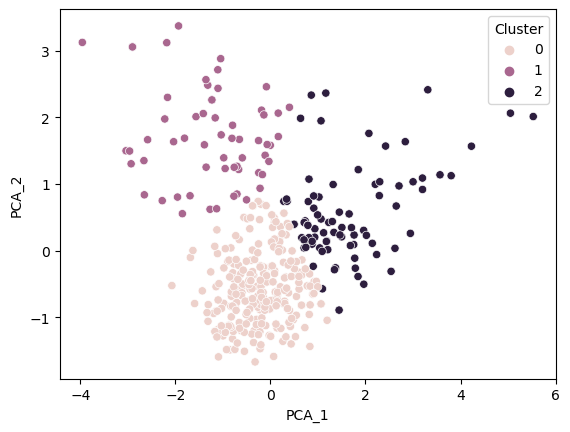

In [38]:
sns.scatterplot(data = enzyme_pca, x = 'PCA_1', y = 'PCA_2', hue = 'Cluster')